# Genarate Data


In [37]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import os

# -----------------------------
# Helper function to create path
def mkpath(name):
    os.makedirs("datasets", exist_ok=True)
    return f"datasets/{name}"

# -----------------------------
# Sri Lanka cities and conditions
cities = ["Colombo", "Galle", "Kandy", "Matara", "Kurunegala", "Anuradhapura", "Trincomalee", "Jaffna", "Batticaloa", "Ratnapura"]
road_types = ["city","highway","rural","coastal"]
weathers = ["sunny","cloudy","light_rain","heavy_rain","monsoon"]
time_of_day_buckets = ["morning","afternoon","evening","night"]

# Vehicle models
vehicle_models = [
    {"make":"Nissan", "model":"Leaf", "eff_kwh_per_km":0.16, "weight_kg":1500},
    {"make":"MG", "model":"ZS EV", "eff_kwh_per_km":0.18, "weight_kg":1650},
    {"make":"BYD", "model":"Atto 3", "eff_kwh_per_km":0.17, "weight_kg":1700},
    {"make":"Tesla", "model":"Model 3", "eff_kwh_per_km":0.15, "weight_kg":1620},
]

# Charging stations
charging_stations = []
station_types = ["AC_7kW","AC_22kW","DC_50kW","DC_120kW"]
for i, city in enumerate(cities, start=1):
    for j in range(3):
        charging_stations.append({
            "station_id": f"CS_{i:02d}_{j+1}",
            "name": f"ChargePoint {city} #{j+1}",
            "city": city,
            "charger_type": random.choice(station_types),
            "num_ports": random.choice([1,2,3]),
            "avg_wait_min": random.randint(0,30),
            "operational": random.choices([True, False], weights=[0.95,0.05])[0]
        })
charging_stations_df = pd.DataFrame(charging_stations)

# -----------------------------
# Helper for origin-destination sampling
def sample_od():
    o = random.choice(cities)
    d = random.choice([c for c in cities if c != o])
    idx_o = cities.index(o)
    idx_d = cities.index(d)
    base = abs(idx_o - idx_d) * 40 + 20
    distance = max(5, int(np.random.normal(base, base * 0.25)))
    elev_gain = int(abs(idx_o - idx_d) * random.uniform(10,50) + (50 if ("Kandy" in (o,d) or "Ratnapura" in (o,d)) else 0))
    return o, d, distance, elev_gain

# -----------------------------
N_TRIPS = 50000  # number of synthetic trips

# 1) Driving Style Dataset
driving_rows = []
for tid in range(N_TRIPS):
    trip_id = f"TR{tid+1:06d}"
    driver_id = f"DRV{random.randint(1,400):04d}"
    vehicle = random.choice(vehicle_models)
    origin, dest, distance_km, elev_gain_m = sample_od()
    trip_duration_min = max(3, int(distance_km / max(10, np.random.normal(45,10)) * 60))
    avg_speed = round(distance_km / (trip_duration_min/60.0) + np.random.normal(0,3), 2)
    max_speed = round(avg_speed + abs(np.random.normal(10,7)), 2)
    style_latent = random.choices(["eco","normal","aggressive"], weights=[0.25,0.6,0.15])[0]
    if style_latent == "eco":
        accel_mean = round(np.random.normal(0.45, 0.05),3) # Reduced noise
        accel_std = round(abs(np.random.normal(0.15,0.05)),3) # Reduced noise
        braking_intensity = round(abs(np.random.normal(0.15,0.05)),3) # Reduced noise
    elif style_latent == "normal":
        accel_mean = round(np.random.normal(0.9, 0.1),3) # Reduced noise
        accel_std = round(abs(np.random.normal(0.4,0.1)),3) # Reduced noise
        braking_intensity = round(abs(np.random.normal(0.3,0.1)),3) # Reduced noise
    else:
        accel_mean = round(np.random.normal(1.8, 0.2),3) # Reduced noise
        accel_std = round(abs(np.random.normal(0.8,0.2)),3) # Reduced noise
        braking_intensity = round(abs(np.random.normal(0.8,0.2)),3) # Reduced noise
    road_type = random.choice(road_types)
    weather = random.choices(weathers, weights=[0.35,0.25,0.15,0.15,0.10])[0]
    time_of_day = random.choice(time_of_day_buckets)
    # label based on simple heuristic
    if accel_mean < 0.6 and accel_std < 0.5 and braking_intensity < 0.4:
        style_label = "Eco"
    elif accel_mean > 1.4 or accel_std > 1.0 or braking_intensity > 0.9:
        style_label = "Aggressive"
    else:
        style_label = "Normal"
    driving_rows.append({
        "trip_id": trip_id, "driver_id": driver_id, "vehicle_make": vehicle["make"], "vehicle_model": vehicle["model"],
        "origin": origin, "destination": dest, "distance_km": distance_km, "elevation_gain_m": elev_gain_m,
        "trip_date": (datetime.now() - timedelta(days=random.randint(0,365))).strftime("%Y-%m-%d %H:%M:%S"),
        "avg_speed": max(0.0, round(avg_speed,2)), "max_speed": max(0.0, round(max_speed,2)),
        "acceleration_mean": max(0.0, accel_mean), "acceleration_std": accel_std, "braking_intensity": braking_intensity,
        "trip_duration_min": trip_duration_min, "road_type": road_type, "weather": weather,
        "time_of_day": time_of_day, "driving_style": style_label
    })
driving_df = pd.DataFrame(driving_rows)
driving_df.to_csv(mkpath("driving_style_dataset_srilanka.csv"), index=False)

# 2) Energy Consumption Dataset
energy_rows = []
for _, row in driving_df.iterrows():
    vehicle = next(v for v in vehicle_models if v["model"] == row["vehicle_model"])
    base_eff = vehicle["eff_kwh_per_km"]
    # Slightly simplified multipliers for potentially clearer relationships
    style_mult = {"Eco":0.9, "Normal":1.0, "Aggressive":1.2}[row["driving_style"]] # Reduced aggressive impact
    traffic_mult = {"city":1.03, "highway":0.97, "rural":1.0, "coastal":1.01}[row["road_type"]] # Reduced variation
    weather_mult = {"sunny":1.0, "cloudy":1.01, "light_rain":1.02, "heavy_rain":1.05, "monsoon":1.08}[row["weather"]] # Reduced variation
    elev_factor = 1 + (row["elevation_gain_m"] / (row["distance_km"]*100+1))*0.5 # Reduced elevation impact
    noise = np.random.normal(0,0.005) # Significantly reduced noise
    energy_kwh = row["distance_km"] * base_eff * style_mult * traffic_mult * weather_mult * elev_factor * (1+noise)
    battery_capacity = random.choice([40,50,60,75])
    battery_start_pct = round(random.uniform(40,100),2)
    battery_start_kwh = battery_capacity * battery_start_pct / 100
    battery_end_kwh = max(0, battery_start_kwh - energy_kwh)
    battery_end_pct = round(battery_end_kwh / battery_capacity * 100,2)
    energy_rows.append({
        "trip_id": row["trip_id"], "vehicle_model": row["vehicle_model"], "distance_km": row["distance_km"],
        "driving_style": row["driving_style"], "road_type": row["road_type"], "weather": row["weather"],
        "elevation_gain_m": row["elevation_gain_m"], "avg_speed": row["avg_speed"],
        "energy_consumed_kWh": round(max(0.01, energy_kwh),3),
        "battery_capacity_kWh": battery_capacity, "battery_start_%": battery_start_pct, "battery_end_%": battery_end_pct
    })
energy_df = pd.DataFrame(energy_rows)
energy_df.to_csv(mkpath("energy_consumption_dataset_srilanka.csv"), index=False)

# 3) Battery Range Dataset
range_rows = []
for _, e in energy_df.iterrows():
    vehicle = next(v for v in vehicle_models if v["model"]==e["vehicle_model"])
    style_eff_mult = {"Eco":0.98,"Normal":1.0,"Aggressive":1.1}[e["driving_style"]] # Reduced variation
    eff = vehicle["eff_kwh_per_km"]*style_eff_mult
    start_kwh = e["battery_capacity_kWh"]*e["battery_start_%"]/100
    max_possible_km = round(start_kwh / eff,2)
    predicted_remaining_km = max(0, round((start_kwh - e["energy_consumed_kWh"]) / eff,2))
    range_rows.append({
        "trip_id": e["trip_id"], "vehicle_model": e["vehicle_model"], "battery_capacity_kWh": e["battery_capacity_kWh"],
        "battery_start_%": e["battery_start_%"], "battery_start_kWh": round(start_kwh,3),
        "eff_kWh_per_km": round(eff,4), "max_possible_km": max_possible_km, "predicted_remaining_km": predicted_remaining_km
    })
range_df = pd.DataFrame(range_rows)
range_df.to_csv(mkpath("battery_range_dataset_srilanka.csv"), index=False)

# 4) Charging Station Recommender Dataset
charge_rows = []
for _, row in driving_df.iterrows():
    origin, dest = row["origin"], row["destination"]
    candidates = [s for s in charging_stations if s["city"] in {origin,dest}]
    if len(candidates)<3:
        intermediate = random.choice([c for c in cities if c not in {origin,dest}])
        candidates += [s for s in charging_stations if s["city"]==intermediate]
    sample_cands = random.sample(candidates, min(3,len(candidates)))
    best_score = 1e9
    best_station = None
    for s in sample_cands:
        base = 5 if s["city"] in {origin,dest} else random.randint(10,60)
        power_factor = 0.8 if "DC" in s["charger_type"] else 1.0
        avail = 1 if s["operational"] else 0.01
        score = base*power_factor/(avail+0.001) + s["avg_wait_min"]*0.1
        if score<best_score:
            best_score = score
            best_station = s
        charge_rows.append({
            "trip_id": row["trip_id"], "station_id": s["station_id"], "station_name": s["name"], "station_city": s["city"],
            "charger_type": s["charger_type"], "num_ports": s["num_ports"], "avg_wait_min": s["avg_wait_min"],
            "operational": s["operational"], "distance_from_route_km": base, "is_recommended": int(s["station_id"]==best_station["station_id"])
        })
charge_df = pd.DataFrame(charge_rows)
charge_df.to_csv(mkpath("charging_recommender_dataset_srilanka.csv"), index=False)

# 5) Optimal Route Dataset
route_rows = []
for tid in range(1000):
    origin = random.choice(cities)
    dest = random.choice([c for c in cities if c!=origin])
    base_distance = random.randint(20,120)
    routes = []
    for r in ["A","B","C"]:
        route_distance = max(5,int(base_distance*random.uniform(0.85,1.15))) # Reduced variation
        avg_speed = max(30,int(np.random.normal(60,8))) # Increased base speed, reduced variation
        traffic_level = random.choice(["low","medium","high"])
        time_min = int(route_distance/max(10,avg_speed)*60*(1 + (0.15 if traffic_level=="high" else 0.03 if traffic_level=="medium" else 0))) # Reduced traffic impact
        veh = random.choice(vehicle_models)
        style = random.choices(["Eco","Normal","Aggressive"], weights=[0.3,0.5,0.2])[0] # Slightly adjusted style distribution
        weather = random.choice(weathers)
        style_mult = {"Eco":0.95,"Normal":1.0,"Aggressive":1.1}[style] # Reduced variation
        weather_mult = {"sunny":1.0,"cloudy":1.01,"light_rain":1.02,"heavy_rain":1.04,"monsoon":1.06}[weather] # Reduced variation
        energy_est = route_distance*veh["eff_kwh_per_km"]*style_mult*weather_mult
        routes.append({
            "route_label": r, "route_distance_km": route_distance, "avg_speed_kmh": avg_speed,
            "traffic_level": traffic_level, "estimated_time_min": time_min,
            "estimated_energy_kWh": round(energy_est,3), "driving_style": style,
            "vehicle_model": veh["model"], "weather": weather
        })
    best = min(routes, key=lambda x: 0.6*x["estimated_energy_kWh"] + 0.4*(x["estimated_time_min"]/60.0)) # Adjusted weighting
    for r in routes:
        route_rows.append({
            "origin": origin, "destination": dest, "route_id": f"{origin}_{dest}_{r['route_label']}",
            **r, "is_optimal": int(r["route_label"]==best["route_label"])
        })
route_df = pd.DataFrame(route_rows)
route_df.to_csv(mkpath("optimal_route_dataset_srilanka.csv"), index=False)

# Charging stations master CSV
charging_stations_df.to_csv(mkpath("charging_stations_master_srilanka.csv"), index=False)

print("Datasets generated in ./datasets folder!")

Datasets generated in ./datasets folder!


#Check Best Model Function

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Regression algorithms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor


def find_best_algorithm(dataset_path, problem_type="classification", target_column=None):
    """
    Evaluate multiple ML algorithms (classification or regression)
    and return the best one with its score.
    """
    df = pd.read_csv(dataset_path)

    # Auto-detect target column
    if target_column is None:
        target_column = df.columns[-1]
        print(f"[INFO] Target column guessed as '{target_column}'")

    # Split features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Encode categorical variables
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define candidate models
    if problem_type.lower() == "classification":
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "KNN": KNeighborsClassifier(),
            "SVM": SVC(),
            "Random Forest": RandomForestClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
        }
        metric_name = "Accuracy"
        metric_fn = accuracy_score
    else:  # regression
        models = {
            "Multiple Linear Regression": LinearRegression(),  # Explicit name for clarity
            "Lasso Regression": Lasso(),
            "Support Vector Regression (SVR)": SVR(),
            "Random Forest Regressor": RandomForestRegressor(),
            "Gradient Boosting Regressor": GradientBoostingRegressor(),
            "XGBoost Regressor": XGBRegressor()
        }
        metric_name = "R² Score"
        metric_fn = r2_score

    # Evaluate models
    results = []
    best_model, best_score = None, -np.inf

    for name, model in models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        pipe.fit(X_train, y_train)
        preds_test = pipe.predict(X_test)
        preds_train = pipe.predict(X_train)

        # Choose metric
        score_test = metric_fn(y_test, preds_test)
        score_train = metric_fn(y_train, preds_train)
        results.append((name, score_train, score_test))

        if score_test > best_score:
            best_score = score_test
            best_model = name

    # Print results
    print("\n📊 Model Evaluation Results:")
    print(f"{'Model Name':<35} | {'Train Score':<15} | {'Test Score':<15}")
    print("-" * 68)
    for name, score_train, score_test in sorted(results, key=lambda x: x[2], reverse=True):
        print(f"{name:<35} | {score_train:<15.4f} | {score_test:<15.4f}")

    print(f"\n✅ Best Algorithm: **{best_model}** with {metric_name} = {best_score:.4f} on the test set.")
    return best_model, best_score

# Handle outliers

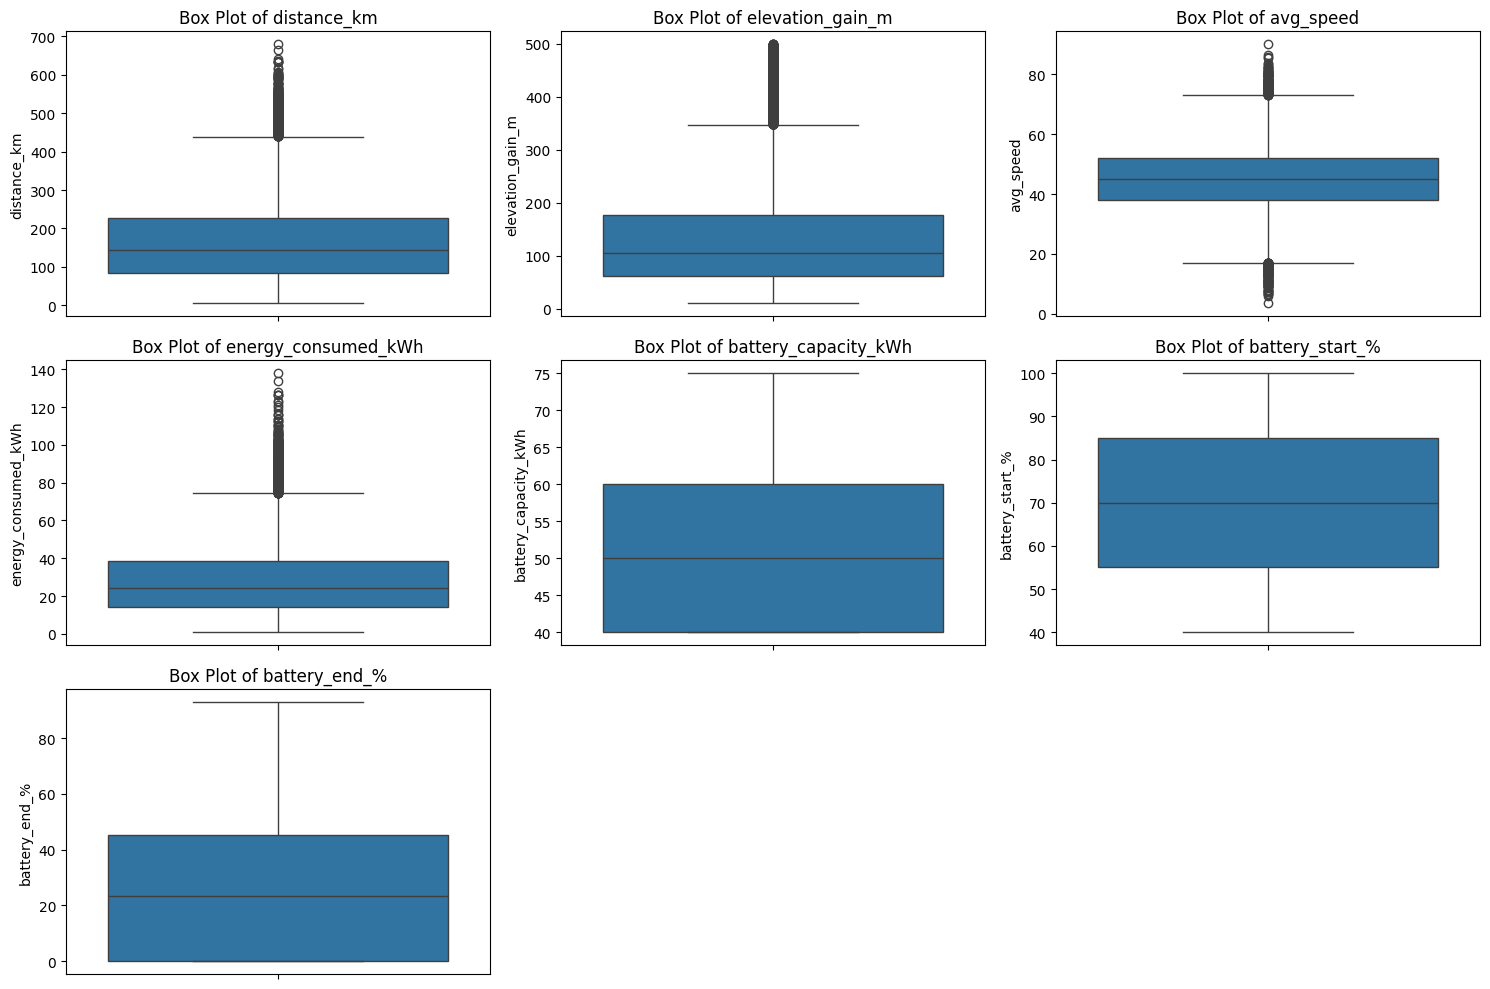

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the energy consumption dataset
energy_df = pd.read_csv(mkpath("energy_consumption_dataset_srilanka.csv"))

# Select numerical columns for outlier detection
numerical_cols = ['distance_km', 'elevation_gain_m', 'avg_speed', 'energy_consumed_kWh', 'battery_capacity_kWh', 'battery_start_%', 'battery_end_%']

# Create box plots to visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=energy_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Removed outliers from 'distance_km'. Remaining rows: 49326
Removed outliers from 'elevation_gain_m'. Remaining rows: 48000
Removed outliers from 'avg_speed'. Remaining rows: 47620
Removed outliers from 'energy_consumed_kWh'. Remaining rows: 47098
Removed outliers from 'battery_capacity_kWh'. Remaining rows: 47098
Removed outliers from 'battery_start_%'. Remaining rows: 47098
Removed outliers from 'battery_end_%'. Remaining rows: 47098

Initial number of rows: 50000
Number of rows after outlier removal: 47098


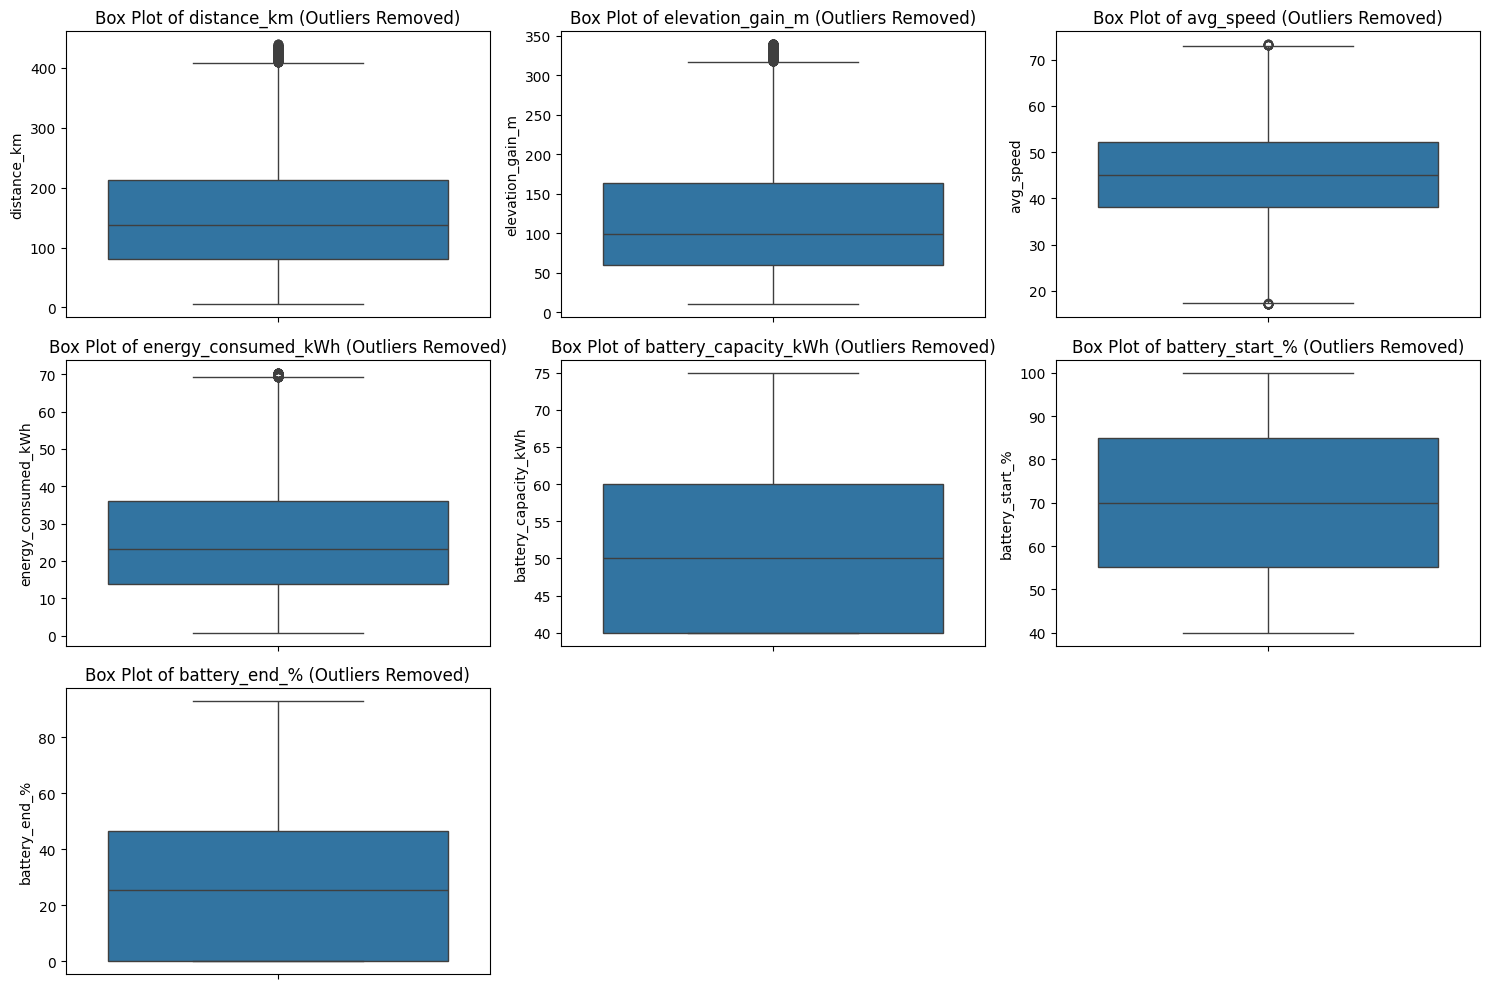

In [40]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_cleaned

# Load the energy consumption dataset again to start fresh
energy_df_cleaned = pd.read_csv(mkpath("energy_consumption_dataset_srilanka.csv"))

# Numerical columns to check for outliers
numerical_cols = ['distance_km', 'elevation_gain_m', 'avg_speed', 'energy_consumed_kWh', 'battery_capacity_kWh', 'battery_start_%', 'battery_end_%']

# Remove outliers from each numerical column
initial_rows = len(energy_df_cleaned)
for col in numerical_cols:
    energy_df_cleaned = remove_outliers_iqr(energy_df_cleaned, col)
    print(f"Removed outliers from '{col}'. Remaining rows: {len(energy_df_cleaned)}")

print(f"\nInitial number of rows: {initial_rows}")
print(f"Number of rows after outlier removal: {len(energy_df_cleaned)}")

# Optionally, display box plots again to see the effect of outlier removal
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=energy_df_cleaned[col])
    plt.title(f'Box Plot of {col} (Outliers Removed)')
plt.tight_layout()
plt.show()

Applied Winsorizing to 'distance_km'.
Applied Winsorizing to 'elevation_gain_m'.
Applied Winsorizing to 'avg_speed'.
Applied Winsorizing to 'energy_consumed_kWh'.
Applied Winsorizing to 'battery_capacity_kWh'.
Applied Winsorizing to 'battery_start_%'.
Applied Winsorizing to 'battery_end_%'.

Winsorizing complete.


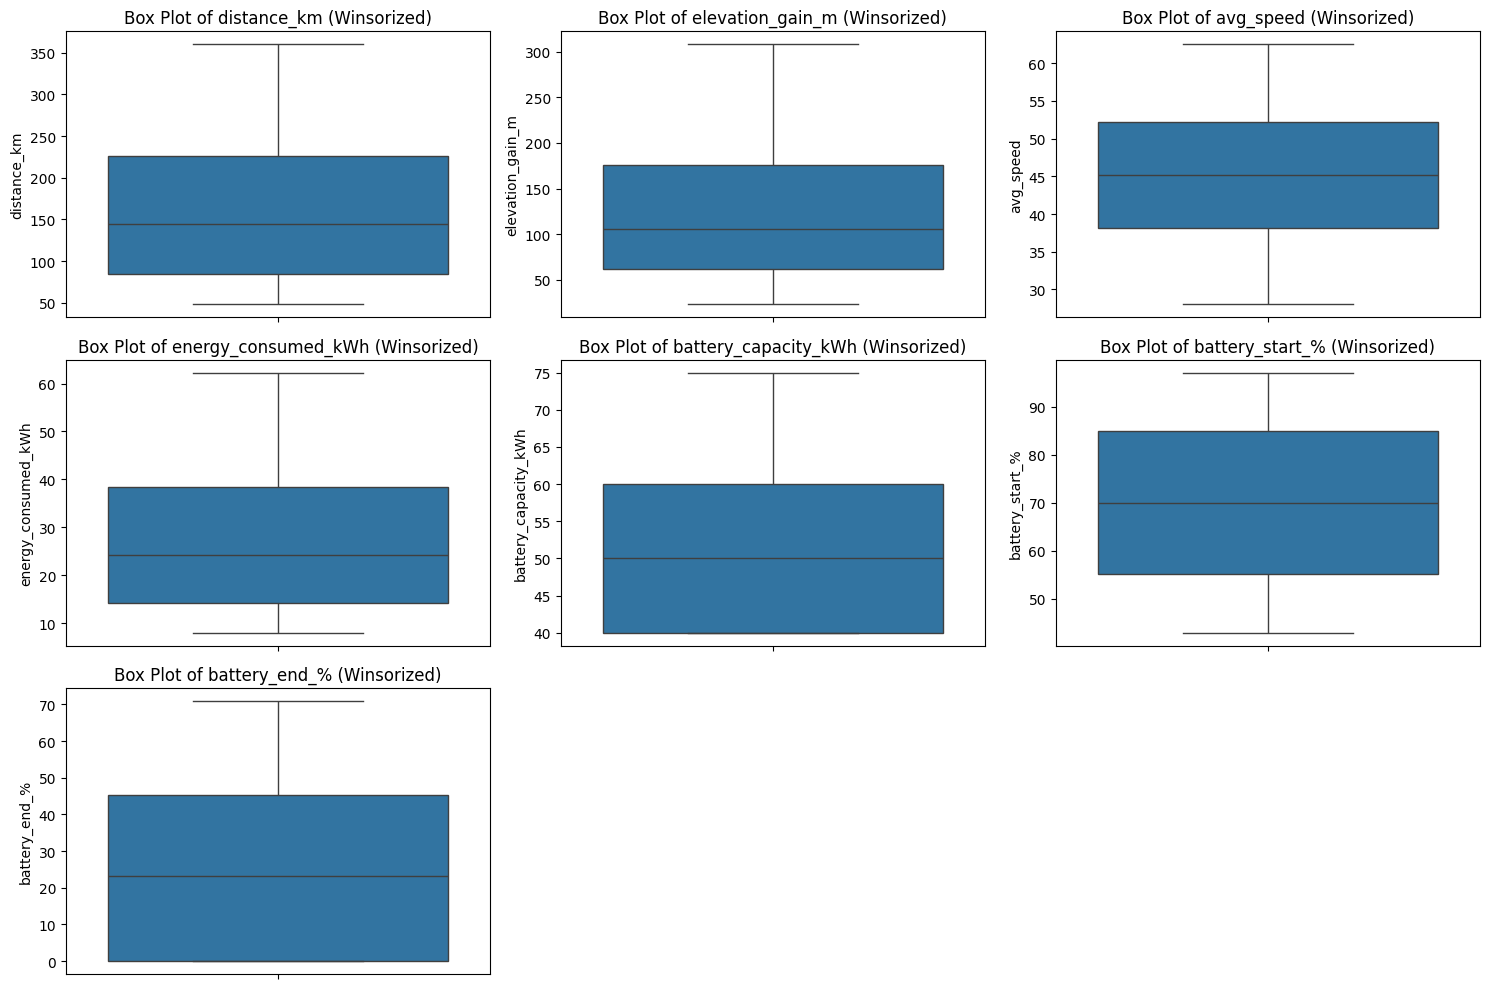

In [41]:
# Function to Winsorize outliers
def winsorize_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df_winsorized = df.copy()
    df_winsorized[column] = df_winsorized[column].clip(lower=lower_bound, upper=upper_bound)
    return df_winsorized

# Load the energy consumption dataset again to start fresh
energy_df_winsorized = pd.read_csv(mkpath("energy_consumption_dataset_srilanka.csv"))

# Numerical columns to apply Winsorizing
numerical_cols = ['distance_km', 'elevation_gain_m', 'avg_speed', 'energy_consumed_kWh', 'battery_capacity_kWh', 'battery_start_%', 'battery_end_%']

# Apply Winsorizing to each numerical column
for col in numerical_cols:
    energy_df_winsorized = winsorize_outliers(energy_df_winsorized, col)
    print(f"Applied Winsorizing to '{col}'.")

print("\nWinsorizing complete.")

# Optionally, display box plots again to see the effect of Winsorizing
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=energy_df_winsorized[col])
    plt.title(f'Box Plot of {col} (Winsorized)')
plt.tight_layout()
plt.show()

# Find best

In [42]:
# Use the find_best_algorithm function to evaluate regression models on the Winsorized energy consumption dataset
find_best_algorithm(dataset_path=mkpath("energy_consumption_dataset_srilanka.csv"),
                    problem_type="regression",
                    target_column="energy_consumed_kWh")


📊 Model Evaluation Results:
Model Name                          | Train Score     | Test Score     
--------------------------------------------------------------------
XGBoost Regressor                   | 0.9997          | 0.9989         
Gradient Boosting Regressor         | 0.9983          | 0.9980         
Random Forest Regressor             | 0.9997          | 0.9976         
Support Vector Regression (SVR)     | 0.9837          | 0.9820         
Multiple Linear Regression          | 0.9580          | 0.9563         
Lasso Regression                    | 0.9488          | 0.9468         

✅ Best Algorithm: **XGBoost Regressor** with R² Score = 0.9989 on the test set.


('XGBoost Regressor', 0.9989450818377095)

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the energy consumption dataset
energy_df_eval = pd.read_csv(mkpath("energy_consumption_dataset_srilanka.csv"))

# Select features (X) and target (y) for evaluation
# Exclude 'trip_id' as it's likely an identifier
X_eval = energy_df_eval.drop(columns=['trip_id', 'energy_consumed_kWh'])
y_eval = energy_df_eval['energy_consumed_kWh']

# Encode categorical variables for evaluation data
for col in X_eval.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_eval[col] = le.fit_transform(X_eval[col])

# Split data into training and testing sets for evaluation
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_eval, y_eval, test_size=0.2, random_state=42)

print("Energy consumption data loaded and prepared for step-by-step evaluation.")
print(f"Evaluation training data shape (X_train_eval, y_train_eval): {X_train_eval.shape}, {y_train_eval.shape}")
print(f"Evaluation testing data shape (X_test_eval, y_test_eval): {X_test_eval.shape}, {y_test_eval.shape}")

Energy consumption data loaded and prepared for step-by-step evaluation.
Evaluation training data shape (X_train_eval, y_train_eval): (40000, 10), (40000,)
Evaluation testing data shape (X_test_eval, y_test_eval): (10000, 10), (10000,)


In [48]:

display(X_train_eval.head())
display(X_test_eval.head())

,vehicle_model,distance_km,driving_style,road_type,weather,elevation_gain_m,avg_speed,battery_capacity_kWh,battery_start_%,battery_end_%
39087,3,411,2,0,2,470,45.30,40,96.27,0.00
30893,0,73,2,3,4,50,32.23,60,48.15,27.64
45278,2,59,2,1,4,96,46.23,75,69.57,57.57
16398,1,170,2,1,1,42,44.70,75,47.62,9.33
13653,3,99,0,2,2,55,42.87,40,84.23,31.21


,vehicle_model,distance_km,driving_style,road_type,weather,elevation_gain_m,avg_speed,battery_capacity_kWh,battery_start_%,battery_end_%
33553,3,201,2,1,0,90,53.28,75,78.25,28.82
9427,0,196,2,2,4,142,32.87,50,95.89,30.73
199,3,327,2,2,4,380,49.19,75,48.76,0.00
12447,3,258,2,2,4,193,48.80,75,42.35,0.00
39489,2,190,1,0,0,99,50.43,50,94.18,40.67


In [44]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the XGBoost Regressor model
# We can use the best parameters found in the tuning step (from cell 349dd443)
# best_params = {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}

# Using the parameters directly for clarity in this step-by-step approach
xgb_model_eval = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="rmse" # Metric used in tuning
)

# Create a pipeline with StandardScaler and the XGBoost model for evaluation
pipeline_eval = Pipeline([("scaler", StandardScaler()), ("model", xgb_model_eval)])

# Train the model using the evaluation training data
print("Training the XGBoost Regressor model for step-by-step evaluation...")
pipeline_eval.fit(X_train_eval, y_train_eval)

print("Model training complete for evaluation.")

Training the XGBoost Regressor model for step-by-step evaluation...
Model training complete for evaluation.


In [45]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate the model on the test set
print("Evaluating the trained model on the evaluation test set...")
y_pred_eval = pipeline_eval.predict(X_test_eval)

# Calculate and print evaluation metrics
rmse_eval = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval)) # RMSE
r2_eval = r2_score(y_test_eval, y_pred_eval) # R-squared

print(f"\nModel Evaluation Results on Evaluation Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse_eval:.4f}")
print(f"R-squared (R2) Score: {r2_eval:.4f}")

Evaluating the trained model on the evaluation test set...

Model Evaluation Results on Evaluation Test Set:
Root Mean Squared Error (RMSE): 0.6158
R-squared (R2) Score: 0.9987


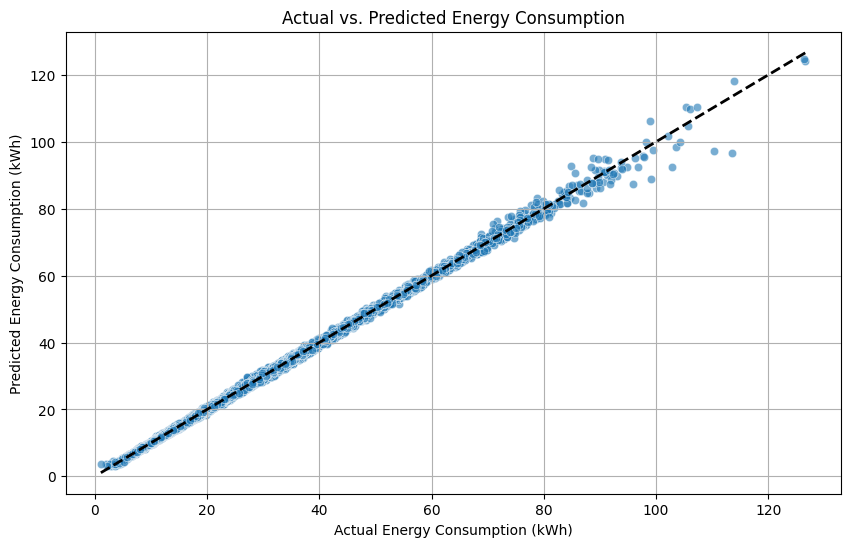

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_eval, y=y_pred_eval, alpha=0.6)
plt.plot([y_test_eval.min(), y_test_eval.max()], [y_test_eval.min(), y_test_eval.max()], 'k--', lw=2) # Add a diagonal line for perfect predictions
plt.xlabel("Actual Energy Consumption (kWh)")
plt.ylabel("Predicted Energy Consumption (kWh)")
plt.title("Actual vs. Predicted Energy Consumption")
plt.grid(True)
plt.show()

In [49]:
import pandas as pd

# Define the input data based on the required columns
# You can change these values to make predictions for different scenarios
input_data = {
    'vehicle_model': [0],  # Example: 0 could represent a specific encoded vehicle model
    'distance_km': [100],
    'driving_style': [1],  # Example: 1 could represent a specific encoded driving style
    'road_type': [2],      # Example: 2 could represent a specific encoded road type
    'weather': [3],        # Example: 3 could represent a specific encoded weather condition
    'elevation_gain_m': [50],
    'avg_speed': [60],
    'battery_capacity_kWh': [75],
    'battery_start_%': [80],
    'battery_end_%': [50]
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(input_data)

# Ensure the column order matches the training data
# This is important because the scaler and model expect features in a specific order
# You can get the column order from X_train_eval or X_test_eval
input_df = input_df[X_train_eval.columns]


# Predict energy consumption using the trained model
predicted_energy_consumption = pipeline_eval.predict(input_df)

print(f"Predicted energy consumption: {predicted_energy_consumption[0]:.4f} kWh")

Predicted energy consumption: 16.8590 kWh


In [50]:
import pickle
from google.colab import files

# Define the filename for the pickle file
filename = 'energy_consumption_model.pkl'

# Save the trained pipeline to a pickle file
with open(filename, 'wb') as f:
    pickle.dump(pipeline_eval, f)

print(f"Trained model saved as {filename}")

# Provide a link to download the file
files.download(filename)

Trained model saved as energy_consumption_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>